In [ ]:
!pip install pycaret

In [2]:
import plotly.express as px
import pandas as pd
import numpy as np
coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEVX_st/meteorological_models/distan_lat42.225lon-8.63p10R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
import pandas as pd
station_all=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEVX_st/meteorological_station/LEVX.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")
print(station_all)
station_all["dir_o"].describe()

                         temp_o     tempd_o    rh_o  dir_o     spd_o  \
time                                                                   
2008-01-01 00:00:00  278.550001  277.950000   95.91  220.0  3.601108   
2008-01-01 01:00:00  278.050000  277.450001   95.89  230.0  3.086664   
2008-01-01 02:00:00  278.050000  277.649999   97.24  190.0  5.144440   
2008-01-01 02:30:00  276.150001  275.149999   93.14  240.0  3.601108   
2008-01-01 03:00:00  278.750001  277.549999   91.98  230.0  3.086664   
...                         ...         ...     ...    ...       ...   
2020-12-24 21:30:00  278.150000  278.150000  100.00   50.0  2.572220   
2020-12-24 22:00:00  278.150000  277.150000   93.24   60.0  2.057776   
2020-12-24 22:30:00  278.150000  277.150000   93.24   80.0  1.543332   
2020-12-24 23:00:00  278.150000  277.150000   93.24   30.0  3.601108   
2020-12-24 23:30:00  278.150000  277.150000   93.24   40.0  3.086664   

                    wind_gust_o  mslp_o  visibility_o skyc1_o s

count    229250.000000
mean        147.828471
std         120.560398
min          -1.000000
25%           0.000000
50%         190.000000
75%         240.000000
max         360.000000
Name: dir_o, dtype: float64

In [5]:
#resample visibility minor hour before
station=station_all[["dir_o","temp_o"]].resample("H",label="right").min()


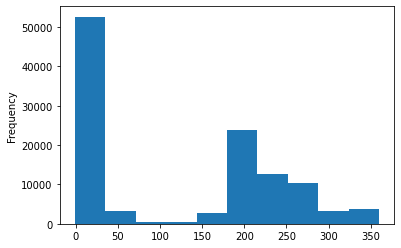

In [6]:
from locale import normalize
#station.value_counts()
station["dir_o"].plot.hist();

In [7]:
#visibility to interval
interval=pd.IntervalIndex.from_tuples([(-1.5, -0.5),(-0.5,20), (20, 40), (40, 60),
                                           (60,80),(80,100),(100,120),(120,140),(140,160),
                                           (160,180),(180,200),(200,220),(220,240),
                                           (240,260),(260,280),(280,300),(300,320),
                                           (320,340),(340,360)])
labels=['VRB', '[0.0, 20.0]', '(20.0, 40.0]', '(40.0, 60.0]',
        '(60.0, 80.0]', '(80.0, 100.0]', '(100.0, 120.0]', '(120.0, 140.0]',
        '(140.0, 160.0]', '(160.0, 180.0]', '(180.0, 200.0]', '(200.0, 220.0]',
        '(220.0, 240.0]', '(240.0, 260.0]', '(260.0, 280.0]', '(280.0, 300.0]',
        '(300.0, 320.0]', '(320.0, 340.0]', '(340.0, 360.0]']

station["dir_l"]=pd.cut(station["dir_o"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
station=station.drop(columns=["temp_o"])
station.sample(20)

,dir_o,dir_l
time,,
2012-03-27 07:00:00,230.0,"(220.0, 240.0]"
2014-10-03 10:00:00,200.0,"(180.0, 200.0]"
2008-08-12 22:00:00,-1.0,VRB
2019-07-09 08:00:00,-1.0,VRB
2010-04-15 11:00:00,110.0,"(100.0, 120.0]"
2011-07-20 06:00:00,30.0,"(20.0, 40.0]"
2014-03-07 19:00:00,-1.0,VRB
2009-07-30 21:00:00,270.0,"(260.0, 280.0]"
2009-06-02 16:00:00,-1.0,VRB


**Forecast D1**

In [8]:
#ria forecast d1
model4k=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEVX_st/meteorological_models/lat42.225lon-8.63p10R4KmD1.csv",parse_dates=["time"]).set_index("time")
model4k

,dir0,mod0,wind_gust0,mslp0,temp0,rh0,visibility0,lhflx0,lwflx0,conv_prec0,...,cape9,cin9,cfh9,cfl9,cfm9,cft9,HGT5009,HGT8509,T5009,T8509
time,,,,,,,,,,,,,,,,,,,,,
2008-01-02 00:00:00,187.022110,8.649026,15.076856,100682.117188,284.099640,0.950480,3850.537842,18.529049,365.889740,0.43,...,0.000000,-0.000117,0.0,1.001866,1.0000,1.001866,5441.062012,1395.217041,250.198868,277.625000
2008-01-02 01:00:00,223.194687,4.872746,8.553699,100766.039062,284.302551,0.952351,24042.478516,7.432752,365.840179,1.41,...,271.859985,-0.630313,1.0,1.003662,1.0000,1.003662,5421.849121,1390.475952,249.379623,276.878235
2008-01-02 02:00:00,213.398468,4.058958,7.745996,100725.421875,283.516113,0.931136,24043.144531,10.536634,361.979858,0.15,...,265.820007,-2.348477,0.0,0.003704,0.0000,0.003704,5403.857910,1385.831055,247.717194,276.178528
2008-01-02 03:00:00,193.151459,4.297006,8.272406,100640.812500,283.482239,0.911970,24036.058594,16.033491,323.539062,0.66,...,271.260010,-4.300562,1.0,0.000267,1.0000,1.000000,5392.368164,1382.380981,247.006317,275.906799
2008-01-02 04:00:00,185.437576,5.599997,9.705170,100599.703125,283.220490,0.917263,24037.439453,16.895048,324.586517,1.60,...,274.359985,-3.418750,1.0,0.003440,1.0000,1.000000,5385.979004,1380.468018,246.807068,276.245819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-12 19:00:00,157.686142,1.743530,4.707931,102008.992188,286.765930,0.922937,24102.066406,4.728705,312.395416,0.00,...,0.000000,-0.002773,0.0,0.500000,0.4000,0.500000,5657.847168,1509.066895,256.351013,281.325867
2020-11-12 20:00:00,132.306030,0.214833,3.802512,102066.460938,286.126678,0.942450,24164.826172,2.759448,370.614349,0.00,...,0.000000,0.000352,0.0,0.300000,0.5000,0.500000,5660.977051,1513.237671,256.373871,281.351135
2020-11-12 21:00:00,136.384262,1.121570,5.705152,102124.367188,286.267761,0.931932,24214.123047,3.625571,351.971375,0.00,...,0.000000,0.000469,0.0,0.300000,0.0625,0.300000,5664.547852,1517.838257,256.420868,280.955627


In [12]:
#label meteorological model prec points 0 to 9
model4k["dir0_l"]=pd.cut(model4k["dir0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
model4k["dir1_l"]=pd.cut(model4k["dir1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
model4k["dir2_l"]=pd.cut(model4k["dir2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
model4k["dir3_l"]=pd.cut(model4k["dir3"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)

In [13]:
#concat station model
df_all4k=pd.concat([station,model4k],axis=1).dropna()
df_all4k=df_all4k.drop(columns=["dir_o"])
df_all4k[["dir_l","dir0_l","dir1_l"]].sample(20)

,dir_l,dir0_l,dir1_l
time,,,
2016-03-19 23:00:00,"[0.0, 20.0]","(100.0, 120.0]","(80.0, 100.0]"
2014-08-30 16:00:00,VRB,"(260.0, 280.0]","(280.0, 300.0]"
2014-01-06 22:00:00,"(160.0, 180.0]","(180.0, 200.0]","(200.0, 220.0]"
2010-10-03 23:00:00,"(280.0, 300.0]","(280.0, 300.0]","(280.0, 300.0]"
2015-01-28 10:00:00,VRB,"(160.0, 180.0]","(140.0, 160.0]"
2009-09-14 05:00:00,"(180.0, 200.0]","(80.0, 100.0]","(80.0, 100.0]"
2008-12-18 22:00:00,"[0.0, 20.0]","(160.0, 180.0]","(160.0, 180.0]"
2020-03-28 17:00:00,"(260.0, 280.0]","(300.0, 320.0]","(280.0, 300.0]"
2015-09-02 07:00:00,VRB,"[0.0, 20.0]","[0.0, 20.0]"


In [15]:
print("station\n",df_all4k["dir_l"].value_counts())
print("point 0\n",df_all4k["dir0_l"].value_counts())



station
 VRB               34338
[0.0, 20.0]       15274
(180.0, 200.0]    12636
(200.0, 220.0]     8616
(160.0, 180.0]     8047
(260.0, 280.0]     6699
(240.0, 260.0]     6132
(220.0, 240.0]     5806
(20.0, 40.0]       4223
(340.0, 360.0]     2673
(280.0, 300.0]     1986
(40.0, 60.0]       1324
(300.0, 320.0]     1175
(320.0, 340.0]     1106
(140.0, 160.0]      696
(60.0, 80.0]        374
(80.0, 100.0]       369
(100.0, 120.0]      241
(120.0, 140.0]      211
Name: dir_l, dtype: int64
point 0
 (260.0, 280.0]    11951
[0.0, 20.0]        9315
(160.0, 180.0]     9138
(280.0, 300.0]     8794
(140.0, 160.0]     7931
(100.0, 120.0]     7516
(120.0, 140.0]     6733
(80.0, 100.0]      6237
(340.0, 360.0]     6132
(180.0, 200.0]     5812
(20.0, 40.0]       5385
(300.0, 320.0]     4911
(240.0, 260.0]     4771
(220.0, 240.0]     4238
(200.0, 220.0]     4123
(320.0, 340.0]     3844
(40.0, 60.0]       2695
(60.0, 80.0]       2400
Name: dir0_l, dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



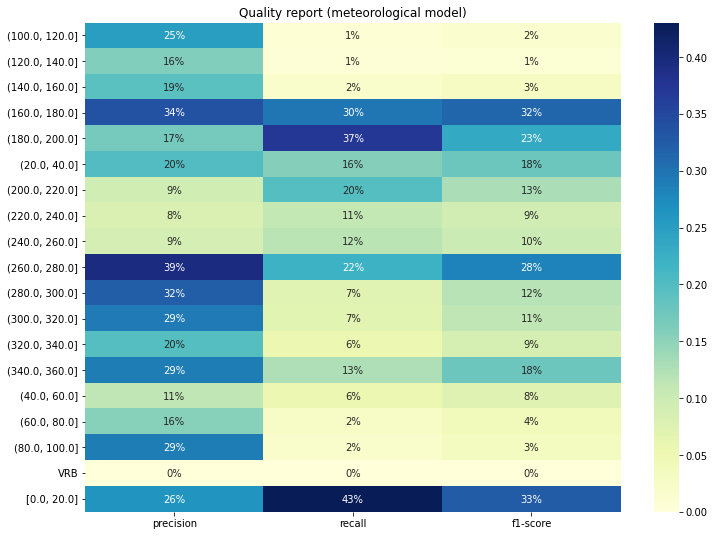

In [23]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Quality report (meteorological model)")
import seaborn as sns
cr=pd.DataFrame(classification_report(df_all4k.dir0_l,df_all4k.dir_l,output_dict=True)).T
sns.heatmap(cr[:-3].drop(columns=["support"]),annot=True,cmap="YlGnBu",fmt='.0%');


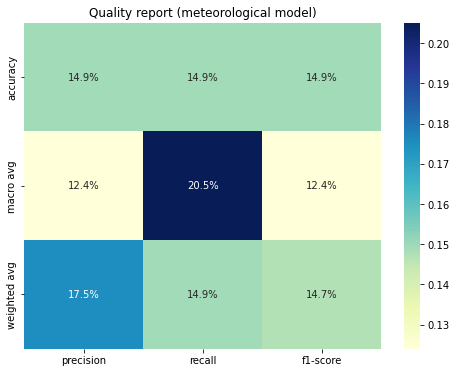

In [17]:
plt.figure(figsize=(8, 6))
plt.title("Quality report (meteorological model)")
sns.heatmap(cr[-3:].drop(columns=["support"]),annot=True,cmap="YlGnBu",fmt='.1%');

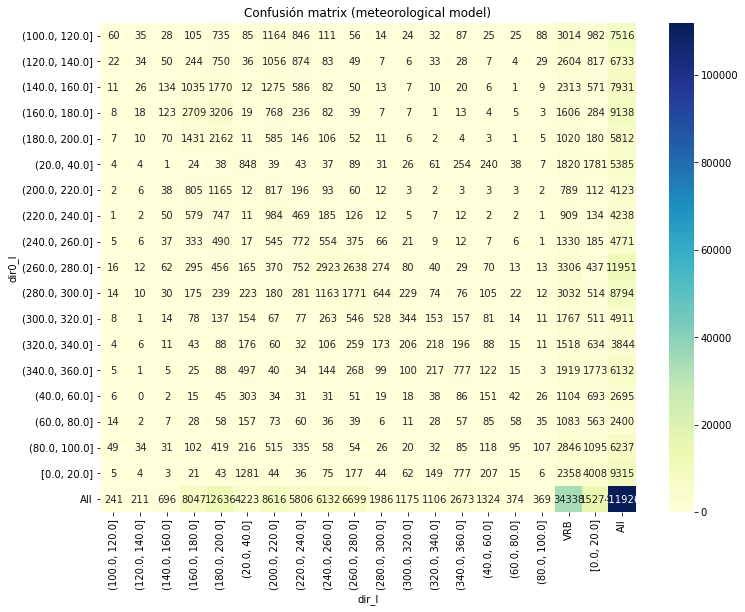

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix (meteorological model)")
import seaborn as sns
global_sc=pd.crosstab( df_all4k.dir0_l,df_all4k.dir_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f');

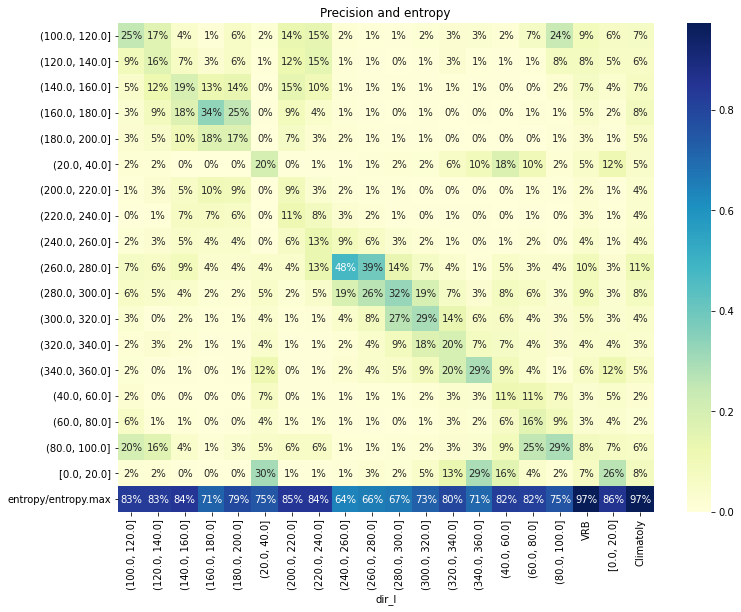

In [21]:
import math
from scipy.stats import entropy
plt.figure(figsize=(12, 9))
plt.title("Precision and entropy")
column_sc=pd.crosstab( df_all4k.dir0_l,df_all4k.dir_l, margins=True,normalize="columns")
column_sc=column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatoly"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%');

**Forecast D0**

In [24]:
#ria forecast d1
ria_model4k=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEVX_st/meteorological_models/lat42.225lon-8.63p10R4KmD0.csv",parse_dates=["time"]).set_index("time")
ria_model4k

,dir0,mod0,wind_gust0,mslp0,temp0,rh0,visibility0,lhflx0,lwflx0,conv_prec0,...,cape9,cin9,cfh9,cfl9,cfm9,cft9,HGT5009,HGT8509,T5009,T8509
time,,,,,,,,,,,,,,,,,,,,,
2008-01-01 01:00:00,144.628357,3.831499,6.448897,102287.132812,280.022430,0.892607,24102.808594,12.980614,293.892212,0.0,...,0.0,-0.000188,1.0,0.000000,0.000000,1.00000,5597.893066,1497.146240,253.327194,277.210388
2008-01-01 02:00:00,147.921097,3.832692,6.672883,102206.570312,280.007874,0.876593,24068.431641,16.218111,301.791016,0.0,...,0.0,0.000039,1.0,0.000000,0.530000,1.00000,5589.398926,1489.944702,252.961868,277.016876
2008-01-01 03:00:00,143.393280,5.442433,8.808276,102199.117188,280.104797,0.852357,24079.357422,30.171259,310.720306,0.0,...,0.0,0.000066,1.0,0.000000,1.000000,1.00000,5583.069824,1489.035278,252.982819,276.464508
2008-01-01 04:00:00,148.121201,5.950326,9.456440,102130.187500,280.257111,0.826763,24082.630859,39.340668,311.036621,0.0,...,0.0,0.000102,1.0,0.000000,1.000000,1.00000,5578.958984,1486.376465,252.923691,276.808807
2008-01-01 05:00:00,144.934830,6.004587,9.431707,102095.398438,280.096802,0.815603,24156.925781,38.444511,268.789703,0.0,...,0.0,-0.000305,0.0,0.000000,0.000000,0.00000,5576.894043,1483.500488,253.006378,277.129700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-11 19:00:00,167.249893,4.803071,10.443219,102130.304688,285.274139,0.883530,24094.119141,30.348995,331.899139,0.0,...,0.0,0.000750,0.6,0.093750,0.000000,0.60000,5669.991211,1510.901978,258.318634,280.277496
2020-11-11 20:00:00,160.990204,5.888032,12.039003,102151.843750,285.359863,0.873678,22888.912109,40.605156,366.950897,0.0,...,0.0,0.000316,0.5,0.500000,0.531250,0.53125,5676.644043,1515.951782,258.397308,280.022552
2020-11-11 21:00:00,169.326263,5.852474,11.513367,102204.882812,285.613678,0.870425,22076.751953,43.137783,367.624512,0.0,...,0.0,-0.000039,0.6,0.500000,0.453125,0.60000,5681.215820,1519.740967,258.154877,280.516174


In [25]:
model4k["dir0_l"]=pd.cut(model4k["dir0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
model4k["dir1_l"]=pd.cut(model4k["dir1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
model4k["dir2_l"]=pd.cut(model4k["dir2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
model4k["dir3_l"]=pd.cut(model4k["dir3"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)

In [27]:
#concat station model
df_all4k=pd.concat([station,model4k],axis=1).dropna()
df_all4k=df_all4k.drop(columns=["dir_o"])
df_all4k[["dir_l","dir0_l","dir1_l"]].sample(20)

,dir_l,dir0_l,dir1_l
time,,,
2010-08-03 07:00:00,"[0.0, 20.0]","[0.0, 20.0]","[0.0, 20.0]"
2013-12-30 19:00:00,"(160.0, 180.0]","(160.0, 180.0]","(160.0, 180.0]"
2020-11-07 23:00:00,"(200.0, 220.0]","(160.0, 180.0]","(160.0, 180.0]"
2011-02-05 06:00:00,"[0.0, 20.0]","(120.0, 140.0]","(120.0, 140.0]"
2016-09-04 18:00:00,"[0.0, 20.0]","(300.0, 320.0]","(320.0, 340.0]"
2015-06-28 14:00:00,"(240.0, 260.0]","(260.0, 280.0]","(280.0, 300.0]"
2010-06-01 11:00:00,"[0.0, 20.0]","(340.0, 360.0]","(340.0, 360.0]"
2010-04-28 21:00:00,"(40.0, 60.0]","(60.0, 80.0]","(40.0, 60.0]"
2009-10-13 06:00:00,"(220.0, 240.0]","(100.0, 120.0]","(80.0, 100.0]"


In [28]:
print("station\n",df_all4k["dir_l"].value_counts())
print("point 0\n",df_all4k["dir0_l"].value_counts())

station
 VRB               34338
[0.0, 20.0]       15274
(180.0, 200.0]    12636
(200.0, 220.0]     8616
(160.0, 180.0]     8047
(260.0, 280.0]     6699
(240.0, 260.0]     6132
(220.0, 240.0]     5806
(20.0, 40.0]       4223
(340.0, 360.0]     2673
(280.0, 300.0]     1986
(40.0, 60.0]       1324
(300.0, 320.0]     1175
(320.0, 340.0]     1106
(140.0, 160.0]      696
(60.0, 80.0]        374
(80.0, 100.0]       369
(100.0, 120.0]      241
(120.0, 140.0]      211
Name: dir_l, dtype: int64
point 0
 (260.0, 280.0]    11951
[0.0, 20.0]        9315
(160.0, 180.0]     9138
(280.0, 300.0]     8794
(140.0, 160.0]     7931
(100.0, 120.0]     7516
(120.0, 140.0]     6733
(80.0, 100.0]      6237
(340.0, 360.0]     6132
(180.0, 200.0]     5812
(20.0, 40.0]       5385
(300.0, 320.0]     4911
(240.0, 260.0]     4771
(220.0, 240.0]     4238
(200.0, 220.0]     4123
(320.0, 340.0]     3844
(40.0, 60.0]       2695
(60.0, 80.0]       2400
Name: dir0_l, dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



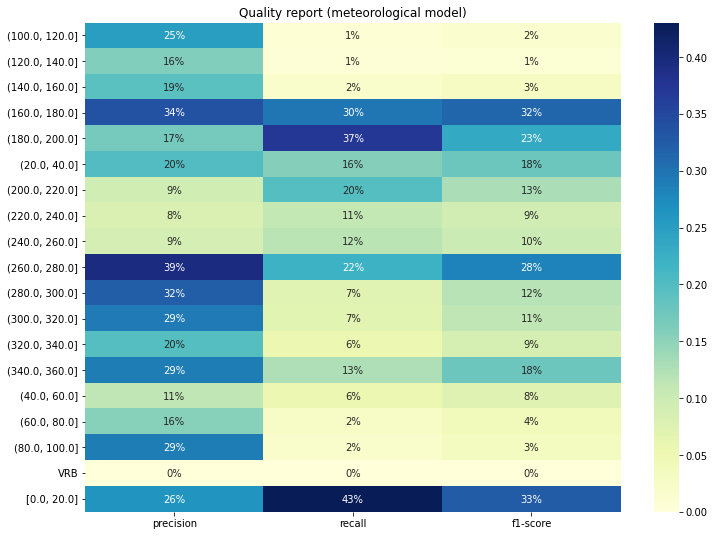

In [29]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Quality report (meteorological model)")
import seaborn as sns
cr=pd.DataFrame(classification_report(df_all4k.dir0_l,df_all4k.dir_l,output_dict=True)).T
sns.heatmap(cr[:-3].drop(columns=["support"]),annot=True,cmap="YlGnBu",fmt='.0%');

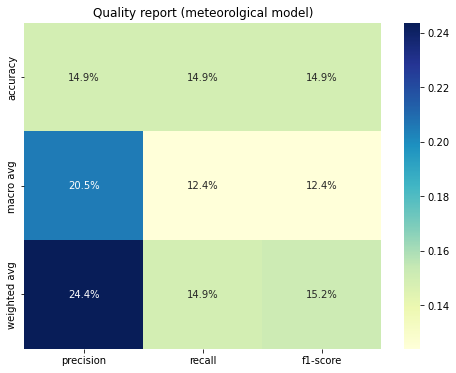

In [30]:
plt.figure(figsize=(8, 6))
plt.title("Quality report (meteorolgical model)")
sns.heatmap(cr[-3:].drop(columns=["support"]),annot=True,cmap="YlGnBu",fmt='.1%');

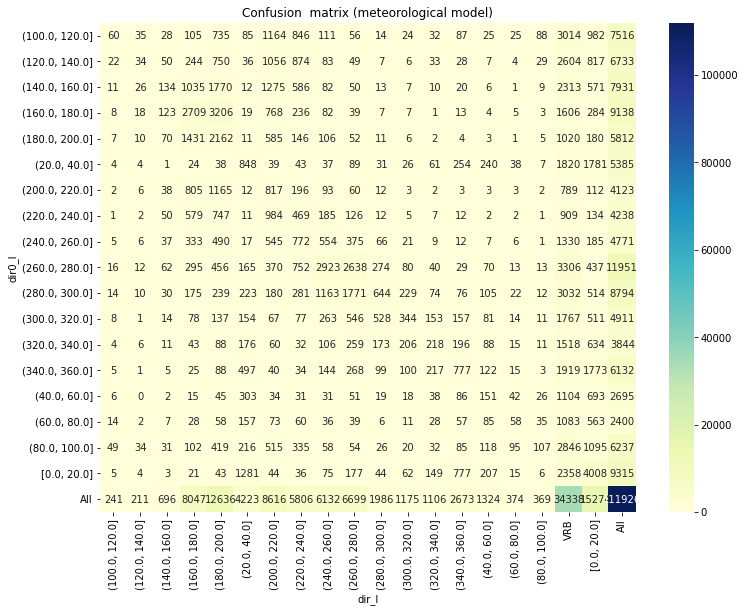

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Confusion  matrix (meteorological model)")
import seaborn as sns
global_sc=pd.crosstab( df_all4k.dir0_l,df_all4k.dir_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f');

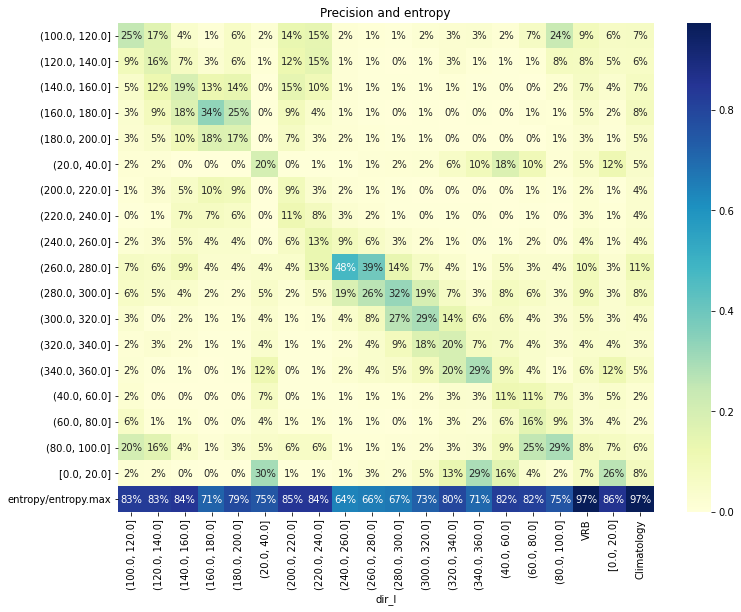

In [36]:
import math
from scipy.stats import entropy
plt.figure(figsize=(12, 9))
plt.title("Precision and entropy")
column_sc=pd.crosstab( df_all4k.dir0_l,df_all4k.dir_l, margins=True,normalize="columns")
column_sc=column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%');

**machine learning d0 or d1**

In [37]:
from pycaret.classification import *
#drop variables model labeled
clas = setup(df_all4k.drop(columns=["dir0_l","dir1_l","dir2_l","dir3_l",]),
             target = 'dir_l',
             session_id=20,normalize=False ,train_size=.85,remove_multicollinearity=True,
             fix_imbalance=False,ignore_low_variance=True,feature_selection=True,
             feature_selection_threshold =.15,pca=False,polynomial_features=False,
             trigonometry_features=False,feature_interaction=False)

              

,Description,Value
0,session_id,20
1,Target,dir_l
2,Target Type,Multiclass
3,Label Encoded,"(100.0, 120.0]: 0, (120.0, 140.0]: 1, (140.0, ..."
4,Original Data,"(111926, 231)"
5,Missing Values,False
6,Numeric Features,230
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [38]:
compare_models(fold=5,sort="F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.3393,0.7049,0.1811,0.3332,0.3334,0.2174,0.2179,8.352
dt,Decision Tree Classifier,0.2970,0.5880,0.1702,0.2988,0.2978,0.1763,0.1763,2.834
lda,Linear Discriminant Analysis,0.3281,0.7149,0.0981,0.2574,0.2545,0.1208,0.1373,1.256
lr,Logistic Regression,0.3393,0.7196,0.0886,0.2566,0.2533,0.1250,0.1462,102.382
ridge,Ridge Classifier,0.3422,0.0000,0.0767,0.2227,0.2298,0.1032,0.1372,1.012
nb,Naive Bayes,0.2304,0.7356,0.1964,0.3084,0.2150,0.1607,0.1694,0.328
qda,Quadratic Discriminant Analysis,0.1922,0.7110,0.1311,0.2782,0.1573,0.1170,0.1306,1.252
dummy,Dummy Classifier,0.3066,0.5000,0.0526,0.0940,0.1439,0.0000,0.0000,0.936


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [40]:
model=create_model("lightgbm",n_estimators=150,fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4179,0.8145,0.1935,0.3980,0.3882,0.2747,0.2834
1,0.4154,0.8137,0.1902,0.3961,0.3877,0.2742,0.2820
2,0.4238,0.8198,0.1963,0.4040,0.3946,0.2828,0.2913
3,0.4215,0.8190,0.1964,0.4027,0.3912,0.2790,0.2879
4,0.4190,0.8172,0.1920,0.3998,0.3879,0.2747,0.2841
Mean,0.4195,0.8168,0.1937,0.4001,0.3899,0.2771,0.2858
SD,0.0029,0.0024,0.0024,0.0029,0.0027,0.0034,0.0034


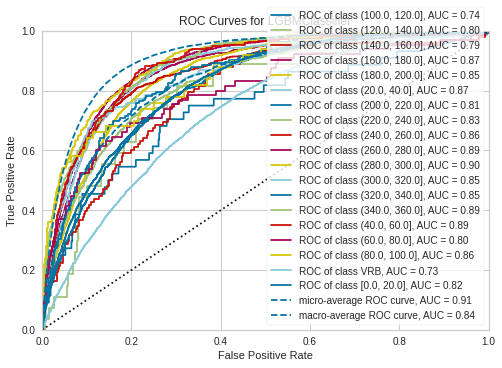

In [41]:
plot_model(model, plot = 'auc')

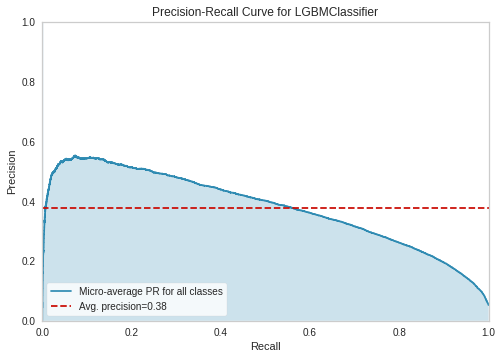

In [42]:
plot_model(model, plot = 'pr')

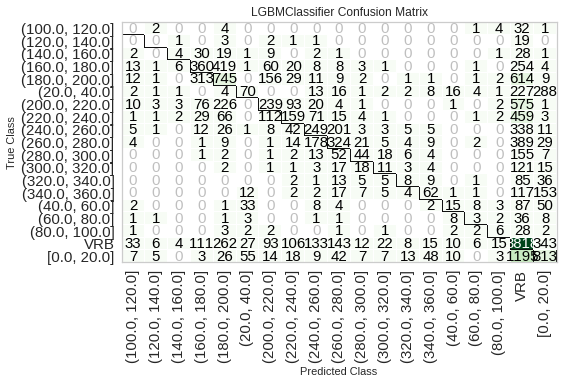

In [43]:
plot_model(model,'confusion_matrix')

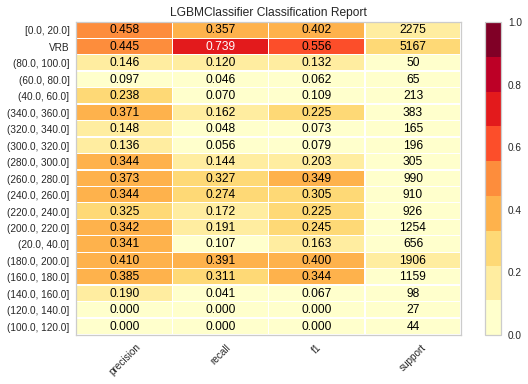

In [44]:
plot_model(model,'class_report')

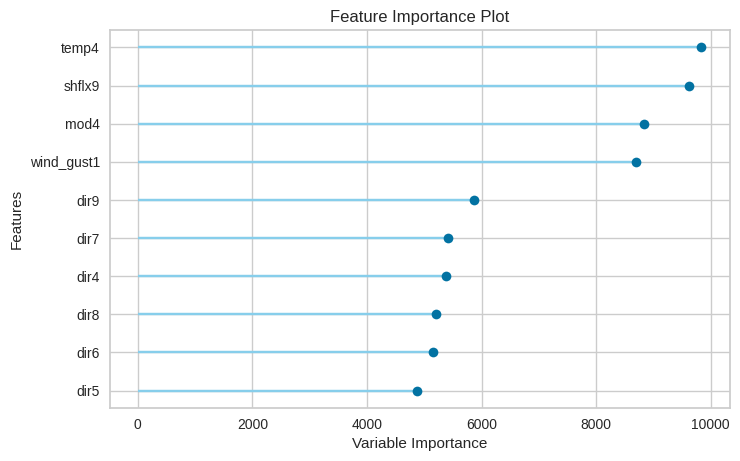

In [45]:
plot_model(model,"feature")

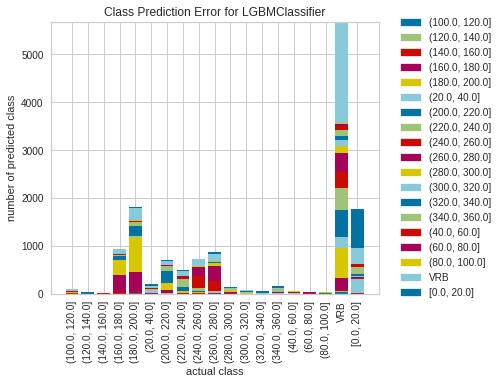

In [46]:
plot_model(model,"error")

**Export model**

In [47]:
x_var=get_config("X_train").columns
x_var

Index(['dir1', 'dir6', 'dir7', 'dir0', 'shflx9', 'dir4', 'dir3', 'mod4',
       'dir2', 'dir5', 'temp4', 'dir8', 'dir9', 'wind_gust1'],
      dtype='object')

In [49]:
#define x and y
Y=df_all4k.dir_l
X=df_all4k[x_var]

In [50]:
#Run the machine learning model
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=1)
#ml_model=ExtraTreesClassifier(n_estimators=150).fit(X_train,y_train)
ml_model=LGBMClassifier(n_estimators=250).fit(X_train,y_train)


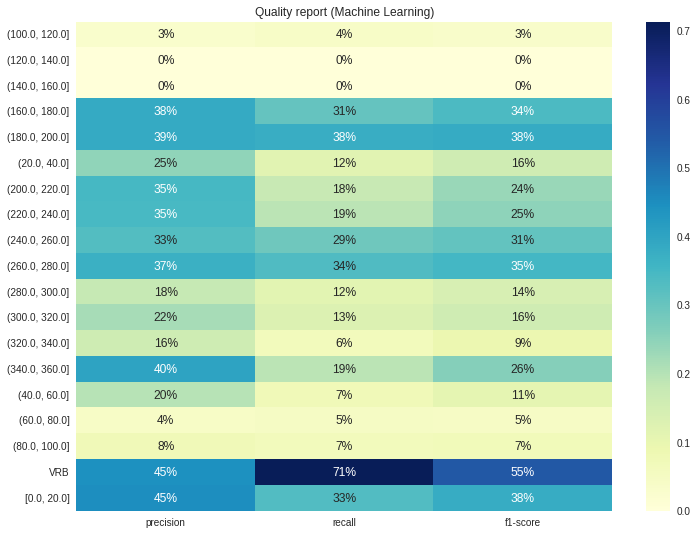

In [51]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
cr=pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
plt.figure(figsize=(12, 9))
plt.title("Quality report (Machine Learning)")
sns.heatmap(cr[:-3].drop(columns=["support"]),annot=True,cmap="YlGnBu",fmt='.0%');


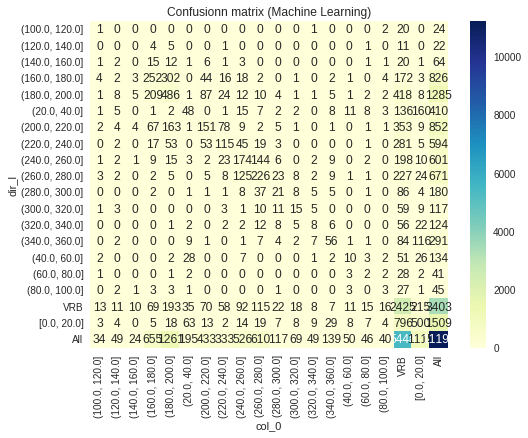

In [52]:
plt.figure(figsize=(8, 6))
plt.title("Confusionn matrix (Machine Learning)")
import seaborn as sns
global_sc=pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f');

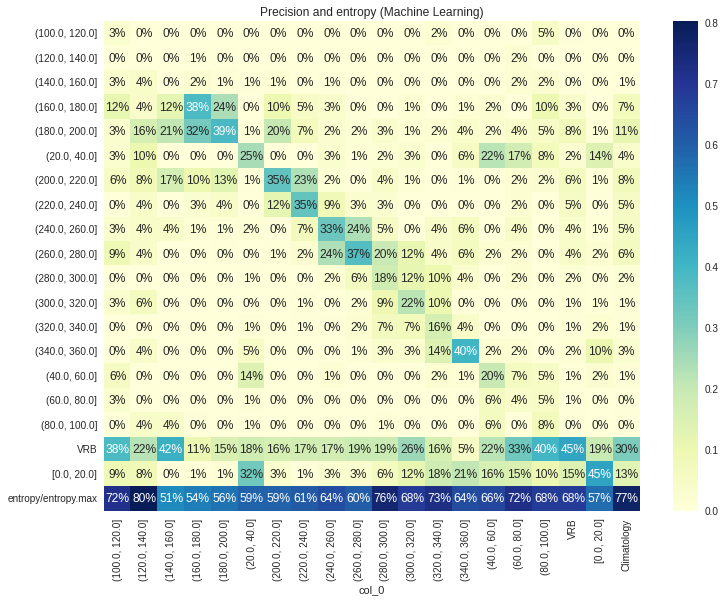

In [53]:
import math
from scipy.stats import entropy
plt.figure(figsize=(12, 9))
plt.title("Precision and entropy (Machine Learning)")
column_sc=pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
column_sc=column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%');

In [54]:
import pickle
model_dict={"x_var":x_var,"ml_model":ml_model,"coor":coor}
pickle.dump(model_dict, open("dir_LEVX_d0.al", 'wb'))